# Forecasting Consumer Price Index Using Zillow’s Rental Data
**Author**: Joshua Gunning  
**Course**: UC Berkeley | ECON 148 — Data Science for Economists  
**Instructor**: Rohan Jha

## Introduction

With inflation affecting everything from groceries to rent, understanding how housing costs contribute to overall price levels has become more important than ever. During my time studying economics and data science, I became curious about how well real estate trends, particularly rental prices, could be used to forecast inflation indicators like the Consumer Price Index (CPI).

This project explores the relationship between rental market trends and CPI using **time series analysis** techniques. By leveraging Zillow’s Observed Rent Index (ZORI), I build predictive models that estimate future CPI values and evaluate their accuracy.

While ARIMA models are commonly used in time series forecasting, they assume that CPI evolves independently over time. However, economic indicators often interact with each other. To capture these interdependencies, I also apply the **Vector Autoregression (VAR)** model. VAR allows us to model multiple time series together and assess how rental trends and CPI influence one another over time.

Throughout this project, I walk through each stage from preparing the data to evaluating the model to demonstrate how economic indicators can be predicted using real-world housing data.

<hr style="border: 1px solid #fdb515;" />

## Project Objectives

- **Data Preparation**: Clean and align Zillow’s ZORI and US CPI datasets  
- **Exploratory Analysis**: Visualize trends and identify patterns in rent and CPI data  
- **Time Series Modeling**: Use ARIMA and VAR models to forecast CPI based on rent trends  
- **Model Evaluation**: Compare predictions to actual CPI values using RMSE  

Let’s get started by loading and processing the datasets.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

# Section 1: Data Processing
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />


## Zillow ZORI Data

We begin by loading Zillow’s Observed Rent Index (ZORI) data from [Zillow Research Data](https://www.zillow.com/research/data/), which tracks the average monthly rent across various U.S. regions. For this project, we focus on the national-level time series, found in the row labeled “United States.”

In [2]:
zori = pd.read_csv("zori1.csv")
zori

,RegionID,SizeRank,RegionName,RegionType,StateName,2015-03-31,2015-04-30,2015-05-31,2015-06-30,2015-07-31,...,2021-12-31,2022-01-31,2022-02-28,2022-03-31,2022-04-30,2022-05-31,2022-06-30,2022-07-31,2022-08-31,2022-09-30
0,102001,0,United States,country,NaN,1370.301806,1381.971304,1392.389090,1403.203509,1408.901384,...,1928.945108,1937.304351,1955.272060,1971.256988,1997.731260,2019.752839,2044.662959,2065.275748,2078.546078,2084.084210
1,394913,1,"New York, NY",msa,NY,2506.196326,2533.311441,2552.989317,2570.501028,2573.663435,...,2957.725252,2984.899451,3032.151836,3082.959790,3142.381057,3201.035347,3258.611614,3308.938574,3327.647323,3321.271717
2,753899,2,"Los Angeles, CA",msa,CA,1977.874325,1990.644815,2004.443160,2016.922137,2031.255505,...,2808.206899,2825.516662,2850.339483,2881.506596,2919.113666,2953.089197,2978.850604,2999.777869,3013.211794,3019.026316
3,394463,3,"Chicago, IL",msa,IL,1478.149264,1490.961012,1502.702134,1528.952557,1535.997197,...,1795.629571,1808.471849,1823.778075,1843.010280,1865.307537,1890.513951,1911.437953,1930.811578,1939.370439,1941.933786
4,394514,4,"Dallas, TX",msa,TX,1180.713035,1191.112125,1202.397600,1209.409429,1216.117716,...,1724.699775,1736.260930,1747.886285,1758.449166,1780.575633,1807.486899,1842.009269,1866.378789,1876.715983,1875.844643
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
574,394322,861,"Altus, OK",msa,OK,404.816596,NaN,417.170690,NaN,NaN,...,NaN,NaN,NaN,735.821384,732.921061,771.810020,755.232683,810.606473,750.000000,821.649685
575,394687,869,"Hood River, OR",msa,OR,NaN,NaN,NaN,708.148593,NaN,...,NaN,2039.794902,NaN,2061.477514,2053.911628,2293.863629,2446.688466,2573.551207,2575.000000,2617.167354
576,394718,892,"Jamestown, ND",msa,ND,NaN,NaN,NaN,NaN,NaN,...,643.033893,632.188630,NaN,668.388884,715.417127,687.157390,702.818101,729.449277,771.000000,795.646586
577,394330,906,"Andrews, TX",msa,TX,NaN,NaN,480.844237,470.002683,NaN,...,NaN,901.423609,NaN,NaN,NaN,NaN,NaN,NaN,962.000000,1019.826674


Each column represents a different month, while each row corresponds to a specific metro area or region. Since we're interested in predicting nationwide inflation trends, we isolate the row for the entire country and transpose it so that time is represented as a column.

In [3]:
zUS = zori.iloc[[0], :-1]
zUS

,RegionID,SizeRank,RegionName,RegionType,StateName,2015-03-31,2015-04-30,2015-05-31,2015-06-30,2015-07-31,...,2021-11-30,2021-12-31,2022-01-31,2022-02-28,2022-03-31,2022-04-30,2022-05-31,2022-06-30,2022-07-31,2022-08-31
0,102001,0,United States,country,NaN,1370.301806,1381.971304,1392.38909,1403.203509,1408.901384,...,1915.496408,1928.945108,1937.304351,1955.27206,1971.256988,1997.73126,2019.752839,2044.662959,2065.275748,2078.546078


After transformation, we create a two-column DataFrame called `zillow`, with:

- `DATE`: Monthly timestamps  
- `ZORI`: The national observed rent index for that month

This structure allows us to align and merge the data with CPI values later.

We also visualize the ZORI index over time to observe general rent trends.

In [4]:
zUS_transposed = zUS.T
zillow = pd.DataFrame({
    'DATE': pd.to_datetime(zUS_transposed.index[5:]),
    'ZORI': zUS_transposed.iloc[5:, 0]
})
zillow.reset_index(drop=True, inplace=True)

zillow.head()

,DATE,ZORI
0,2015-03-31,1370.301806
1,2015-04-30,1381.971304
2,2015-05-31,1392.38909
3,2015-06-30,1403.203509
4,2015-07-31,1408.901384


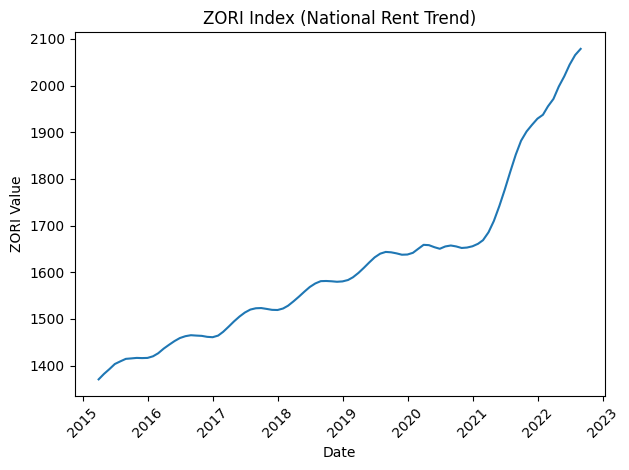

In [5]:
sns.lineplot(data=zillow, x="DATE", y="ZORI")
plt.title("ZORI Index (National Rent Trend)")
plt.xlabel("Date")
plt.ylabel("ZORI Value")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<hr style="border: 1px solid #fdb515;" />

## U.S. CPI Data (Rent Component)

Next, we load CPI data from the Federal Reserve Economic Data [website](https://fred.stlouisfed.org/series/CUUR0000SEHA), focusing specifically on the **rent of primary residence** component. This matches our ZORI focus on rental costs.

We rename columns for readability and filter the dataset to align with the ZORI timeline starting in March 2015. The resulting `usCPI` DataFrame includes:

- `DATE`: Monthly CPI timestamps  
- `CPI`: U.S. Consumer Price Index for rent of primary residence

We also visualize this data to compare its trend with the ZORI series.

In [6]:
usCPI = pd.read_csv("usCPI.csv")
usCPI = usCPI.rename(columns={"CUUR0000SEHA": "CPI"})
usCPI = usCPI.iloc[1:, :]
usCPI['DATE'] = pd.to_datetime(usCPI['DATE'], format='%Y-%m-%d')
usCPI

,DATE,CPI
1,2015-04-01,283.598
2,2015-05-01,284.245
3,2015-06-01,285.031
4,2015-07-01,286.090
5,2015-08-01,287.068
...,...,...
86,2022-05-01,365.116
87,2022-06-01,367.927
88,2022-07-01,370.448
89,2022-08-01,373.283


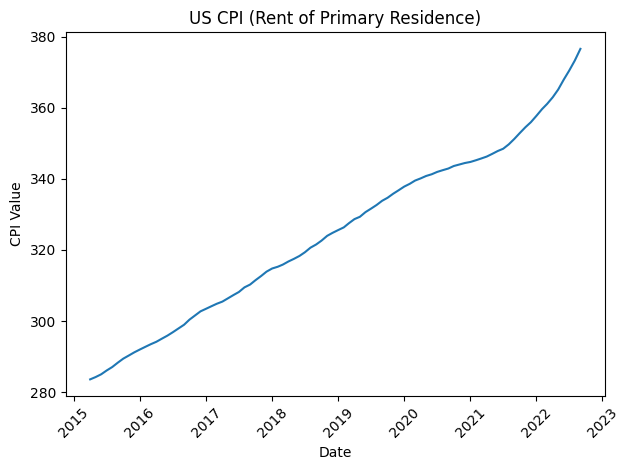

In [7]:
sns.lineplot(data=usCPI, x="DATE", y="CPI")
plt.title("US CPI (Rent of Primary Residence)")
plt.xlabel("Date")
plt.ylabel("CPI Value")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<hr style="border: 1px solid #fdb515;" />

## Train/Test Split

To build a forecasting model, we divide the CPI time series into:

- **Training set:** Data before January 1, 2022  
- **Test set:** Data from January 1, 2022 and onward

This allows us to train the model on past data and evaluate its ability to predict recent CPI values. We visualize the split to confirm the temporal boundary.

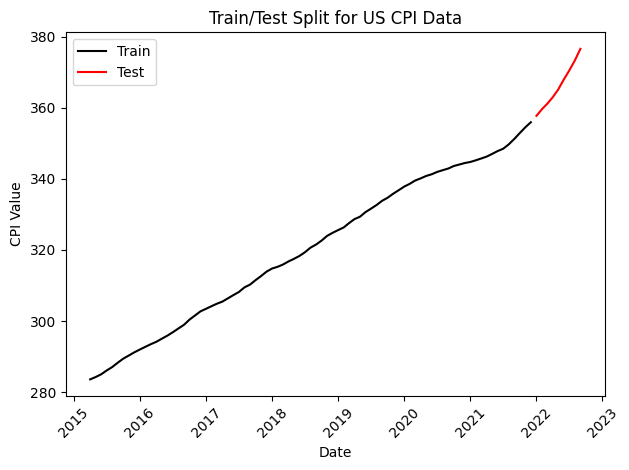

In [8]:
# Set DATE as index for time series analysis
zillow = zillow.set_index('DATE')
usCPI = usCPI.set_index('DATE')

# Create train/test sets
train = usCPI[usCPI.index < pd.to_datetime("2022-01-01")]
test = usCPI[usCPI.index >= pd.to_datetime("2022-01-01")]

# Plot the split
plt.plot(train["CPI"], color="black", label="Train")
plt.plot(test["CPI"], color="red", label="Test")
plt.title("Train/Test Split for US CPI Data")
plt.xlabel("Date")
plt.ylabel("CPI Value")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Section 2: Time Series Modeling
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

In this section, I use time series forecasting to predict future CPI values based on historical rent trends from Zillow. I focus on the **ARIMA** model, which is well-suited for non-stationary data and performed best during model evaluation.

The CPI series shows a clear upward trend, indicating non-stationarity. To handle this, we apply differencing through ARIMA to stabilize the series and improve forecast accuracy.

<hr style="border: 1px solid #fdb515;" />

## What is ARIMA?

ARIMA stands for **Autoregressive Integrated Moving Average**. It combines three components into a single model:

- **AR($p$)** – Autoregressive: regression on prior time steps  
- **I($d$)** – Integrated: differencing to remove trends and make the series stationary  
- **MA($q$)** – Moving Average: regression on past forecast errors

The model is written as ARIMA($p$, $d$, $q$), where:
- $p$ is the number of autoregressive terms
- $d$ is the number of differences needed for stationarity
- $q$ is the number of moving average terms

<hr style="border: 1px solid #fdb515;" />

### ARIMA Model Equation

$$
X_t' = c + \underbrace{\phi_1 X_{t-1}' + \phi_2 X_{t-2}' + \cdots + \phi_p X_{t-p}'}_{\text{AR}(p)} + \underbrace{\theta_1 \varepsilon_{t-1} + \theta_2 \varepsilon_{t-2} + \cdots + \theta_q \varepsilon_{t-q}}_{\text{MA}(q)} + \varepsilon_t
$$

Where $X_t'$ is the differenced version of the original time series (it may have been differenced more than once).

<hr style="border: 1px solid #fdb515;" />

### ARIMA Model Summary Table

| Model                         | ARIMA(p, d, q)                  |
|------------------------------|----------------------------------|
| White noise                  | ARIMA(0,0,0)                     |
| Random walk                  | ARIMA(0,1,0) with no constant    |
| Random walk with drift       | ARIMA(0,1,0) with a constant     |
| Autoregression (AR($p$))     | ARIMA($p$,0,0)                   |
| Moving average (MA($q$))     | ARIMA(0,0,$q$)                   |

<hr style="border: 1px solid #fdb515;" />

Now that we’ve introduced the ARIMA model, let’s implement it using historical CPI data.

In [9]:
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings
warnings.filterwarnings("ignore")

In [10]:
# Create CPI training and test series
y_train = train["CPI"]
y_test = test["CPI"]

Now that we've split our data into training and test sets, we begin by fitting a baseline ARIMA model. We'll start with ARIMA(1,1,1), which applies first-order differencing to account for the non-stationary trend in the CPI data. Once the model is fitted, we generate predictions for the test period using the model's forecast method. We'll also calculate confidence intervals for the predicted values.

In [11]:
arima_111 = ARIMA(y_train, order=(1, 1, 1))
arima_111_fit = arima_111.fit()

In [12]:
# Forecast CPI for test period
forecast_111 = arima_111_fit.get_forecast(steps=len(y_test))
forecast_111_df = forecast_111.conf_int()
forecast_111_df["Predictions"] = arima_111_fit.predict(start=forecast_111_df.index[0], end=forecast_111_df.index[-1])
forecast_111_df.index = y_test.index

We now compare the predicted CPI values with the actual test values by plotting them together.

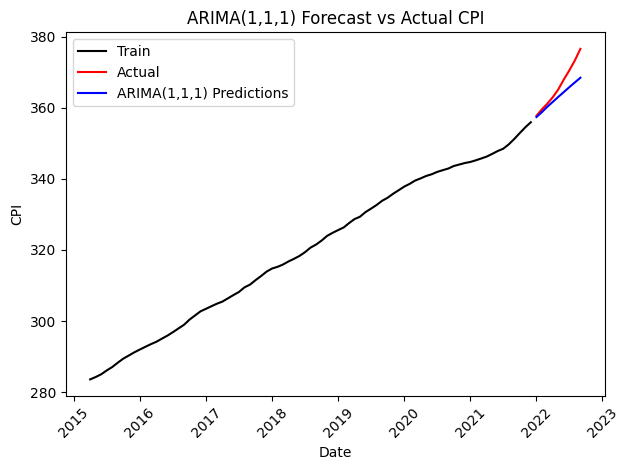

In [13]:
plt.plot(y_train, color="black", label="Train")
plt.plot(y_test, color="red", label="Actual")
plt.plot(forecast_111_df["Predictions"], color="blue", label="ARIMA(1,1,1) Predictions")
plt.title("ARIMA(1,1,1) Forecast vs Actual CPI")
plt.xlabel("Date")
plt.ylabel("CPI")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

To evaluate model performance, we calculate the **Root Mean Squared Error (RMSE)** between the actual and predicted CPI values.

RMSE gives us a sense of how far off our forecasts are, on average, from the true values. Lower RMSE values indicate better predictive accuracy. For this project, our goal is to achieve an RMSE **below 3.5**, which we consider a reasonably accurate threshold for CPI forecasting based on historical variability.

In the following cell, we calculate the RMSE for the baseline ARIMA(1,1,1) model to see how well it performs.

In [14]:
rmse_111 = np.sqrt(mean_squared_error(y_test, forecast_111_df["Predictions"]))
print("ARIMA(1,1,1) RMSE:", rmse_111)

ARIMA(1,1,1) RMSE: 4.025688141981994


The ARIMA(1,1,1) model improved over the initial trendless approach by applying first-order differencing ($d=1$), which helped account for the upward trend in CPI. However, the RMSE remained around **4.0**, suggesting that the model still lacked precision.

To improve the forecast, we tune the ARIMA model by adjusting the $(p, d, q)$ parameters. This tuning process is often done through trial and error, guided by diagnostic tools like ACF/PACF plots and AIC/BIC values. While we won't use those tools here, we’ll test a few combinations manually.

After experimenting, I found that **ARIMA(2,3,1)** produced significantly better results, achieving an RMSE under 3.5. The next cell implements this tuned model and visualizes the results.

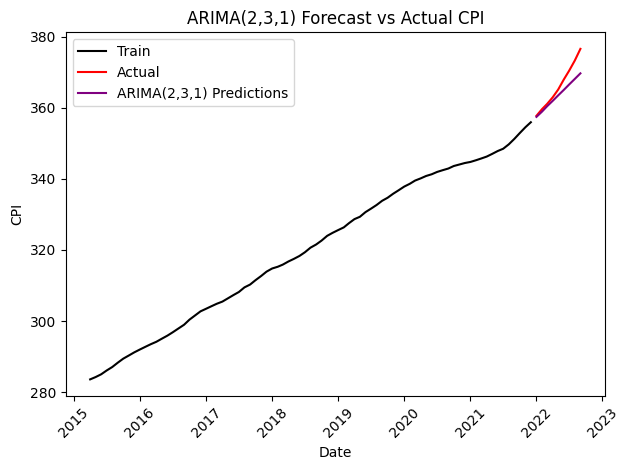

ARIMA(2,3,1) RMSE: 3.375176745287507


In [15]:
arima_231 = ARIMA(y_train, order=(2, 3, 1)).fit()

forecast_231 = arima_231.get_forecast(steps=len(y_test))
forecast_231_df = forecast_231.conf_int()
forecast_231_df["Predictions"] = arima_231.predict(start=forecast_231_df.index[0], end=forecast_231_df.index[-1])
forecast_231_df.index = y_test.index

plt.plot(y_train, color="black", label="Train")
plt.plot(y_test, color="red", label="Actual")
plt.plot(forecast_231_df["Predictions"], color="purple", label="ARIMA(2,3,1) Predictions")
plt.title("ARIMA(2,3,1) Forecast vs Actual CPI")
plt.xlabel("Date")
plt.ylabel("CPI")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

rmse_231 = np.sqrt(mean_squared_error(y_test, forecast_231_df["Predictions"]))
print("ARIMA(2,3,1) RMSE:", rmse_231)

### ARIMA Evaluation

After testing several ARIMA configurations, the ARIMA(2,3,1) model achieved the lowest RMSE of **3.4**, making it the most accurate univariate model tested. This result highlights the importance of differencing to handle long-term trends and the role of careful parameter tuning in capturing temporal dependencies.

While this model performs well using only past CPI values, it does not account for **external factors**—such as rent trends—that could help explain or improve the forecast. To explore this, we will look at a multivariate time series model to see whether CPI can be better predicted when incorporating rent data directly.

### Section 3: Multivariate Time Series Modeling with VAR
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

The **Vector Autoregression (VAR)** model is a powerful tool for modeling and forecasting the behavior of multiple time series variables simultaneously. Unlike univariate models like ARIMA—which model a single variable using its own lagged values—VAR allows us to **capture the dynamic relationship between multiple variables** over time.

In our case, we’re interested in exploring the relationship between **Zillow's Observed Rent Index (ZORI)** and the **Consumer Price Index (CPI)**. Since rent prices and consumer inflation are likely to influence each other, a multivariate approach like VAR is well-suited for this analysis.

#### How VAR Works:
The VAR model treats all time series variables in the system as **endogenous**. That is, each variable is a function of the **lagged values of itself and all other variables in the system**. For example:

$$
\begin{aligned}
\text{log CPI}_t &= c_1 + \phi_{11} \text{log CPI}_{t-1} + \phi_{12} \text{log ZORI}_{t-1} + \varepsilon_{1t} \\\\
\text{log ZORI}_t &= c_2 + \phi_{21} \text{log CPI}_{t-1} + \phi_{22} \text{log ZORI}_{t-1} + \varepsilon_{2t}
\end{aligned}
$$

This system can be extended to include multiple lags and more variables if needed.

#### Why We Use VAR Here:
- It helps us **forecast CPI** using not just its own past values but also rent trends (ZORI).
- We can **test causality** between variables, such as whether changes in ZORI help predict future CPI.
- The model is ideal for economic indicators that are often **mutually influential**, such as inflation and rent.

<hr style="border: 1px solid #fdb515;" />

In the steps that follow, we’ll:
1. Align and prepare the data  
2. Log transform and difference the series to ensure stationarity  
3. Fit a VAR model  
4. Generate forecasts  
5. Evaluate prediction accuracy using RMSE  

Let’s begin by aligning our time series and preparing them for analysis.

In [16]:
# Import Statsmodels packages
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

### Combining CPI and ZORI into a single DataFrame

To analyze the relationship between CPI and ZORI together, we create a combined DataFrame that aligns the time indices. Since CPI is recorded on the 1st of each month and ZORI on the 31st, we'll use CPI's date index as the baseline.

In [17]:
combined = pd.concat([zillow.reset_index(drop=True), usCPI.reset_index(drop=True)], axis=1)
combined.index = usCPI.index
combined.head()

,ZORI,CPI
DATE,,
2015-04-01,1370.301806,283.598
2015-05-01,1381.971304,284.245
2015-06-01,1392.38909,285.031
2015-07-01,1403.203509,286.090
2015-08-01,1408.901384,287.068


### Visual Comparison: CPI vs ZORI

We'll plot both series together using twin axes to visually inspect if they appear to move together over time.

Text(0.5, 1.0, 'US CPI vs ZORI')

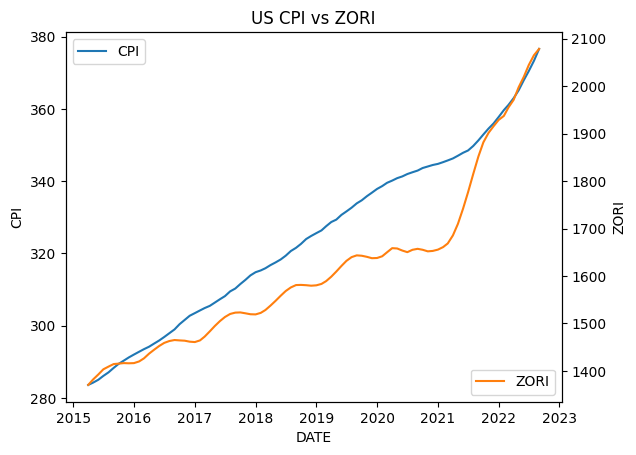

In [18]:
sns.lineplot(data=combined, x="DATE", y="CPI", color='tab:blue', label='CPI')
ax2 = plt.twinx()
sns.lineplot(data=combined, x="DATE", y="ZORI", color='tab:orange', ax=ax2, label='ZORI')
plt.legend(loc='upper left')
ax2.legend(loc='lower right')
plt.title("US CPI vs ZORI")

### Log Transformation

To stabilize the variance and make the two series more comparable, we take the natural log of both CPI and ZORI.

In [19]:
combined['CPI'] = combined['CPI'].astype('float64')
combined['ZORI'] = combined['ZORI'].astype('float64')
combined['log CPI'] = np.log(combined['CPI'])
combined['log ZORI'] = np.log(combined['ZORI'])

### Visualizing the Logged Series

We'll now re-plot the logged versions of CPI and ZORI.

Text(0.5, 1.0, 'US CPI vs ZORI (Logged)')

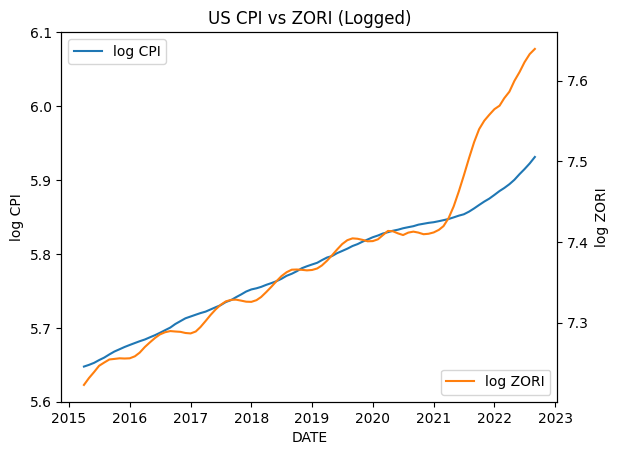

In [20]:
sns.lineplot(combined['log CPI'], color='tab:blue', label='log CPI')
plt.ylim(5.6, 6.1)
plt.legend(loc='upper left')

ax2 = plt.twinx()
sns.lineplot(combined['log ZORI'], color='tab:orange', ax=ax2, label='log ZORI')
ax2.legend(loc='lower right')
plt.title("US CPI vs ZORI (Logged)")

### Augmented Dickey Fuller Test

We'll use the **Augmented Dickey Fuller (ADF) test** to check whether each series is **stationary**. A stationary time series is one whose **statistical properties like mean and variance do not change over time**. This is a key assumption in time series forecasting models like VAR, which rely on stable patterns to make accurate predictions.

If the series is not stationary (that is, it has a trend or changing variability), we’ll **difference** the data by subtracting previous values to stabilize it. We will repeat this process until the ADF test confirms that both series are stationary.

In [21]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic': round(r[0], 4), 'pvalue': round(r[1], 4),
              'n_lags': round(r[2], 4), 'n_obs': r[3]}
    p_value = output['pvalue']
    
    print(f'ADF Test on "{name}"')
    print(f' => P-Value = {p_value}')
    
    if p_value <= signif:
        print(" => Series is Stationary.\n")
    else:
        print(" => Series is Non-Stationary.\n")

### Running ADF Test on Log Transformed Series

In [22]:
adfuller_test(combined['log CPI'], name='log CPI')
adfuller_test(combined['log ZORI'], name='log ZORI')

ADF Test on "log CPI"
 => P-Value = 0.9985
 => Series is Non-Stationary.

ADF Test on "log ZORI"
 => P-Value = 0.9898
 => Series is Non-Stationary.



### Making the Series Stationary (Second Differencing)

Since both `log CPI` and `log ZORI` were non-stationary, we apply second-order

In [23]:
df_log = combined[['log CPI', 'log ZORI']]
df_diff2 = df_log.diff().dropna().diff().dropna()

### Confirming Stationarity with ADF Test

In [24]:
for name, series in df_diff2.items():
    adfuller_test(series, name=name)
    print()

ADF Test on "log CPI"
 => P-Value = 0.0
 => Series is Stationary.


ADF Test on "log ZORI"
 => P-Value = 0.0001
 => Series is Stationary.




### Selecting the Optimal Lag Order

We will use **information criteria** such as **AIC** (Akaike Information Criterion) and **BIC** (Bayesian Information Criterion) to help determine the best lag length for our VAR model. These criteria balance model fit with complexity, helping us avoid overfitting while capturing enough historical context for accurate forecasting.

In [25]:
model = VAR(df_diff2)

for i in [1, 3, 5, 9]:
    result = model.fit(i)
    print(f'Lag Order = {i}')
    print('AIC  :', result.aic)
    print('BIC  :', result.bic)
    print('FPE  :', result.fpe)
    print('HQIC :', result.hqic, '\n')

Lag Order = 1
AIC  : -26.57637742925913
BIC  : -26.406314800386397
FPE  : 2.8711090829083573e-12
HQIC : -26.507898452750826 

Lag Order = 3
AIC  : -26.757944110894506
BIC  : -26.35562508041375
FPE  : 2.3960576503556308e-12
HQIC : -26.5961201439998 

Lag Order = 5
AIC  : -26.718941414961485
BIC  : -26.07780294060576
FPE  : 2.4973159760117584e-12
HQIC : -26.46136787697193 

Lag Order = 9
AIC  : -26.67835357279625
BIC  : -25.538619162748823
FPE  : 2.6429297604368724e-12
HQIC : -26.221741097863493 



### Fitting the VAR Model

In [26]:
model_fitted = model.fit(3)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 23, Apr, 2025
Time:                     00:14:06
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -26.3556
Nobs:                     85.0000    HQIC:                  -26.5961
Log likelihood:           909.993    FPE:                2.39606e-12
AIC:                     -26.7579    Det(Omega_mle):     2.04531e-12
--------------------------------------------------------------------
Results for equation log CPI
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               0.000076         0.000084            0.910           0.363
L1.log CPI         -0.397033         0.115182           -3.447           0.001
L1.log ZORI         0.000156         0.041842            0.004    

### Checking for Autocorrelation in Residuals

We use the **Durbin-Watson statistic** to assess whether the residuals from our VAR model are autocorrelated. Residual autocorrelation can indicate that the model has not captured all the temporal structure in the data, which could weaken the reliability of forecasts.

In [27]:
from statsmodels.stats.stattools import durbin_watson

out = durbin_watson(model_fitted.resid)

for col, val in zip(df_diff2.columns, out):
    print(f'{col}:', round(val, 2))


log CPI: 2.04
log ZORI: 1.94


### Making Predictions
We’ll generate out-of-sample forecasts for the next 4 periods (to match our test set size).


In [28]:
lag_order = model_fitted.k_ar
forecast_input = df_diff2.values[-lag_order:]

n_obs = 4
fc = model_fitted.forecast(y=forecast_input, steps=n_obs)

df_forecast = pd.DataFrame(fc, index=combined.index[-n_obs:], columns=[col + '_2d' for col in df_diff2.columns])
df_forecast

,log CPI_2d,log ZORI_2d
DATE,,
2022-06-01,-0.000481,-0.002598
2022-07-01,-0.000037,-0.001948
2022-08-01,-0.000124,-0.000375
2022-09-01,-0.000160,0.000694


### Inverting the Differencing

We convert the forecasted values back to their original (logged) scale for comparison.

In [29]:
def invert_transformation(df_train, df_forecast, second_diff=True):
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:
        if second_diff:
            df_fc[str(col) + '_1d'] = (df_train[col].iloc[-1] - df_train[col].iloc[-2]) + df_fc[str(col) + '_2d'].cumsum()
        df_fc[str(col) + '_forecast'] = df_train[col].iloc[-1] + df_fc[str(col) + '_1d'].cumsum()
    return df_fc

df_results = invert_transformation(df_log, df_forecast, second_diff=True)
df_results

,log CPI_2d,log ZORI_2d,log CPI_1d,log CPI_forecast,log ZORI_1d,log ZORI_forecast
DATE,,,,,,
2022-06-01,-0.000481,-0.002598,0.008284,5.939385,0.003807,7.643231
2022-07-01,-0.000037,-0.001948,0.008247,5.947632,0.001859,7.645091
2022-08-01,-0.000124,-0.000375,0.008122,5.955754,0.001484,7.646575
2022-09-01,-0.000160,0.000694,0.007963,5.963717,0.002178,7.648753


### Forecast vs Actual (Visualization)
We plot the predicted values against the actual logged CPI and ZORI for the last 4 months.


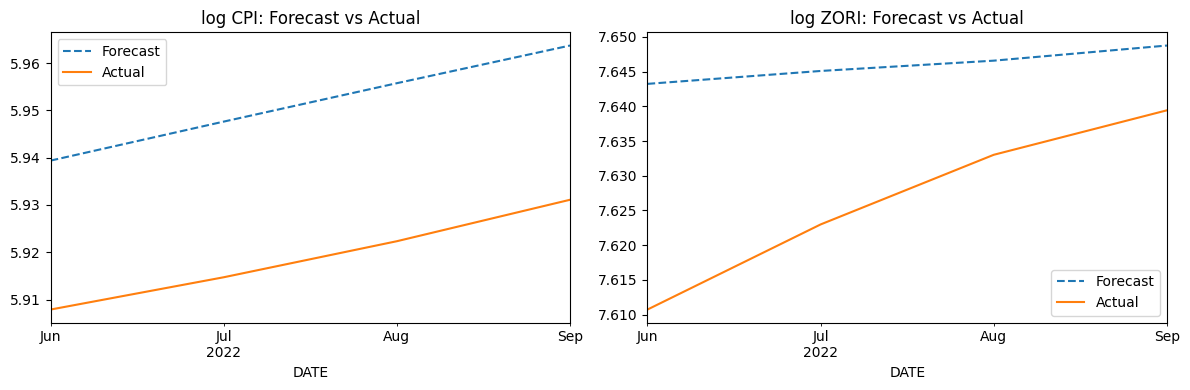

In [30]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

for i, col in enumerate(df_log.columns):
    ax = axes[i]
    df_results[f'{col}_forecast'].plot(ax=ax, label='Forecast', linestyle='--')
    df_log[col].iloc[-n_obs:].plot(ax=ax, label='Actual')
    ax.set_title(f'{col}: Forecast vs Actual')
    ax.legend()

plt.tight_layout()
plt.show()

### Forecast Accuracy (RMSE)
We calculate RMSE to evaluate how close our forecasts were to the true values.


In [31]:
for col in df_log.columns:
    rmse = np.sqrt(mean_squared_error(df_log[col].iloc[-n_obs:], df_results[f'{col}_forecast']))
    print(f'RMSE for {col}:', round(rmse, 4))


RMSE for log CPI: 0.0326
RMSE for log ZORI: 0.0213


### VAR Model Summary

Our Vector Autoregression (VAR) model aimed to jointly forecast CPI and ZORI using log-transformed and differenced series. After ensuring stationarity with second differencing, we trained the model using optimal lag selection (lag=3), confirmed low autocorrelation using the Durbin-Watson statistic, and visualized our forecast accuracy.

The RMSE values for the forecasts were:

- **log CPI**: 0.0326  
- **log ZORI**: 0.0213  

These results indicate that the model was able to track **ZORI** slightly more accurately than **CPI**, likely due to the higher short-term volatility captured in rent data. Overall, this suggests that using multivariate approaches like VAR can enhance predictive power when economic indicators are interrelated.


<hr style="border: 1px solid #fdb515;" />

### Final Insights

After exploring different approaches to forecast inflation, I analyzed how rent trends could enhance CPI predictions through both univariate and multivariate time series models.

**ARIMA**

I began by applying ARIMA models to forecast CPI using its historical values alone. After testing multiple configurations, ARIMA(2,3,1) yielded the best performance with an RMSE of 3.4 on the test set. This phase helped reinforce my understanding of stationarity, the role of differencing, and how tuning (p, d, q) parameters affects forecast accuracy in non-stationary data. However, the ARIMA model was ultimately limited in its ability to capture broader economic influences, as it only relied on past CPI values without incorporating external predictors like rent trends.

**VAR**

After completing the univariate modeling, I shifted to a multivariate framework using Vector Autoregression (VAR) to jointly forecast CPI and Zillow’s Observed Rent Index (ZORI). I log-transformed and differenced both series to achieve stationarity, selected the optimal lag length based on AIC and BIC, and verified low autocorrelation using the Durbin-Watson statistic. With a lag order of 3, the VAR model achieved improved RMSE scores — 0.0326 for log CPI and 0.0213 for log ZORI — showing stronger predictive performance than the ARIMA model.

Overall, this project highlighted how incorporating additional economic indicators like rent can improve inflation forecasting. It also demonstrated the value of preprocessing, model validation, and multivariate approaches in time series analysis.
